In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1. Đọc file CSV và xử lý dữ liệu
from google.colab import files
uploaded = files.upload()

Saving hanoi_quality.csv to hanoi_quality.csv


In [2]:
data = pd.read_csv("hanoi_quality.csv", parse_dates=['date'], dayfirst=True)
data = data.set_index('date')

df1 = data['pm25']

scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 2. Chia train test
train_size = int(len(df1) * 0.9)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size, :], df1[train_size:len(df1), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [3]:
# 3. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [4]:
# 4. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# 5. Dự báo dữ liệu test
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/100
27/27 [==============================] - 15s 250ms/step - loss: 0.0352 - val_loss: 0.0326
Epoch 2/100
27/27 [==============================] - 3s 128ms/step - loss: 0.0224 - val_loss: 0.0314
Epoch 3/100
27/27 [==============================] - 3s 104ms/step - loss: 0.0218 - val_loss: 0.0309
Epoch 4/100
27/27 [==============================] - 4s 154ms/step - loss: 0.0219 - val_loss: 0.0330
Epoch 5/100
27/27 [==============================] - 3s 109ms/step - loss: 0.0215 - val_loss: 0.0311
Epoch 6/100
27/27 [==============================] - 3s 121ms/step - loss: 0.0215 - val_loss: 0.0339
Epoch 7/100
27/27 [==============================] - 1s 52ms/step - loss: 0.0212 - val_loss: 0.0305
Epoch 8/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0211 - val_loss: 0.0303
Epoch 9/100
27/27 [==============================] - 2s 67ms/step - loss: 0.0208 - val_loss: 0.0299
Epoch 10/100
27/27 [==============================] - 2s 85ms/step - loss: 0.0203 - val_loss:

In [5]:
# 6. Đánh giá mô hình
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true, axis=0)
    y_pred_diff = np.diff(y_pred, axis=0)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_score_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
test_score_mda = calculate_mda(y_test, y_pred)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 35.37029323013417
MAPE trên tập test là: 63.553604813968114 %
MDA trên tập test là: 43.125 %


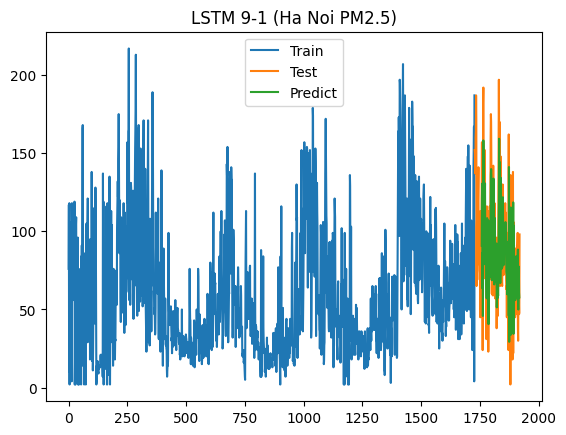

In [6]:
# 7. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))
pred_data_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(pred_data_index, y_pred)
plt.title('LSTM 9-1 (Ha Noi PM2.5)')
plt.legend(['Train', 'Test', 'Predict'])
plt.show()

1/1 [==============================] - 0s 25ms/step


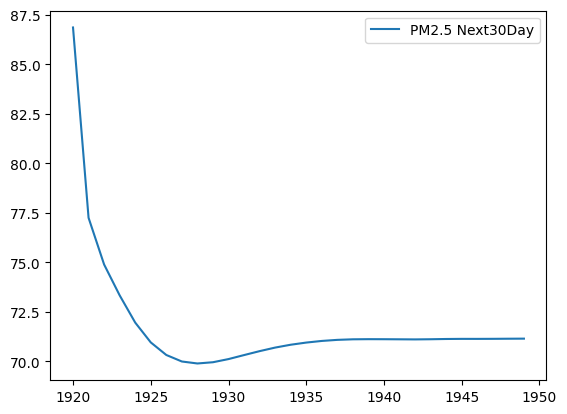

In [7]:
# 8. Dự đoán 30 ngày tiếp theo
last_30_days = df1[-time_step:]
pred_input = last_30_days.reshape(1, -1, 1)

next_30_days = []
for _ in range(30):
    pred = model.predict(pred_input)
    next_30_days.append(pred[0][0])
    pred_input = np.append(pred_input[:, 1:, :], [[pred[0]]], axis=1)

next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))

# Thêm dự đoán vào biểu đồ
future_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_data_index, next_30_days)
plt.legend(['PM2.5 Next30Day'])
plt.show()